Strong perturbation
===================


Contrary to the "weak perturbation" experiment we do now address the case of a velocity perturbation of the order (or larger) than the sound speed $c = \sqrt{T}$.
As for the simulations in section 3 the initial condition is translationally invariant in the y direction, i.e. the simulations are one dimensional.

In [1]:
root_path  = "/home/katanovic/fluid_kinetic_class/2024/run/strong"
phare_path = "/home/katanovic/PHARE/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_path, "pyphare"))
sys.path.append(os.path.join(root_path, "2024"))

from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
from pyphare.pharesee.run import Run
%matplotlib widget

In [3]:
def get_velocities(r,times, sigma=6):
    for it,t in enumerate(times):
        Vi = r.GetVi(t, merged=True)
        Vix = Vi["Vx"][0]
        xV = Vi["Vx"][1][0]
        if sigma >0:
            v = gf(Vix(xV),sigma)
        else:
            v = Vix(xV)
        if it==0 :
            vt = np.zeros((len(v),len(times)))
        vt[:,it] = v
    return xV, vt

def get_pressures(r,times, sigma=6):
    for it,t in enumerate(times):
        P = r.GetPi(t, merged=True)
        Pi = P["Pxx"][0]
        x = P["Pxx"][1][0]
        if sigma >0:
            p = gf(Pi(x),sigma)
        else:
            p = Pi(x)
        if it==0 :
            pt = np.zeros((len(p),len(times)))
        pt[:,it] = p
    return x, pt
    
    
def get_electric(r,times, sigma=6):
    for it,t in enumerate(times):
        E = r.GetE(t, merged=True)
        Ex = E["Ex"][0]
        x = E["Ex"][1][0]
        if sigma >0:
            e = gf(Ex(x),sigma)
        else:
            e = Ex(x)
        if it==0 :
            et = np.zeros((len(e),len(times)))
        et[:,it] = e
    return x, et   

def profiles(times, x, Vs, vmin=None,vmax=None, marker=None, **kw):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:5.2f}".format(t), marker=marker)
        ax.set_ylim((-2.5, 2.5))
        ax.axhline(0, ls='--', color='k')
        if vmin is not None and vmax is not None:
            ax.set_ylim((vmin,vmax))
    ax.legend(ncol=4)

def get_densities(r,times, sigma=6):
    for it,t in enumerate(times):
        N = r.GetNi(t, merged=True)
        Ni = N['value']
        x = N["rho"][1][0]
        if sigma >0:
            n = gf(Ni(x),sigma)
        else:
            n = Ni(x)
        if it==0 :
            nt = np.zeros((len(n),len(times)))
        nt[:,it] = n
    return x, nt



def phase_space(time, r, **kwargs):

    ions = r.GetParticles(time, ["protons",])
    vmin = kwargs.get("vmin", -2)
    vmax = kwargs.get("vmax", 2)    
    dv   = kwargs.get("dv", 0.05)
    nvbins = int((vmax-vmin)/dv)
    vbins = vmin + dv*np.arange(nvbins)
    nxbins = kwargs.get("nxbins", 64)
    dx     = kwargs.get("dx", 0.2)
    xbins = dx*np.arange(nxbins)+dx/2


    fig, (ax1,ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    p,f=ions.dist_plot(axis=("x", "Vx"),
                       ax=ax1,
                       norm=0.4,                 
                       # levels=(0,),  # default is (0,), tuple of all levels to overplot
                       # bulk=True,  # draw line(s) at mean vel. on vel. axis
                       # xlim=(0,20),  # default takes full data range
                       # ylim=(-2,2),  # default takes full data range
                       # sigma = (1,1),  # gaussian filter 2D
                       # filename=myImage.png,  # will save result in file
                       gaussian_filter_sigma=0,
                       bins=(xbins,vbins),
                       title="Strong perturbation at time : {:.2f}".format(time), # figure title
                       # xlabel="my x label", # default is name of chosen axis[0]
                       # ylabel= "my y label", # default is name of chosen axis[1]
                       # kde = True,     # default False, draws kernel density estimate contours
                       interp=True,
                      )
    
    xcuts  = kwargs.get("xcuts", (2, 10.0))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(xcuts)]
    for xcut,color in zip(xcuts, colors):
        
        ax1.axvline(xcut, ls="--", color=color)
        d,xbin,ybin= f[2:5]
        ax2.plot(ybin, d(xcut, ybin), label=f"x = {xcut}")
        ax2.set_yscale("log")
        ax2.legend()
        ax2.set_title("cuts")

    return fig, ax1, ax2, p, f

## Goal

You will execute 3 runs. The runs only differ by the electron and ion temperatures. 

- $T_e = 0.005$, $T_i=0.005$
- $T_e = 0.125$, $T_i=0.005$
- $T_e = 0.25$, $T_i=0.025$

## Run PHARE

- Open a terminal (File>New>Terminal)
- execute `pwd`, you should see `/home/user/PHARE` indicating you're in the PHARE directory
- execute `git clone https://github.com/PHAREHUB/fluid_kinetic_class`
- execute `cd fluid_kinetic_class/2024/run/strong/`


In there you will see a script called `wp1.py` that will configure a PHARE simulation for you.\
To run it :

```bash
python3 sp.py 0.25 0.025
```

The first argument being Te, the second Ti

This should run and produce outputs in the directory:

- `wp_0.25_0.025/`


To run the analysis for a specific run you did, execute cells below after changing the value of the variable  `Te` and `Ti` to the one associated with the run you want to see.



In [4]:
Te = 0.25
Ti = 0.025

path = f"{root_path}/sp_{Te}_{Ti}"

In [5]:
times   = np.asarray((0, 2, 4, 6, 8, 10))
r = Run(path)

# Fluid quantities

Below, let's investigate the profiles of the bulk velocity, density and electric field over time.

In [6]:
x, Vs = get_velocities(r,times, sigma=0)

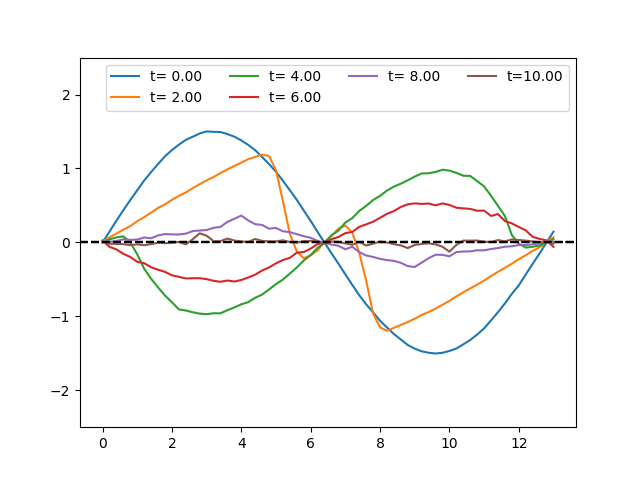

In [7]:
profiles(times, x, Vs)

In [8]:
x, Ns   = get_densities(r,times, sigma=0)

KeyError: 'value'

In [ ]:
profiles(times, x, Ns, -0.2, 10)

In [9]:
x, E   = get_electric(r,times, sigma=8)

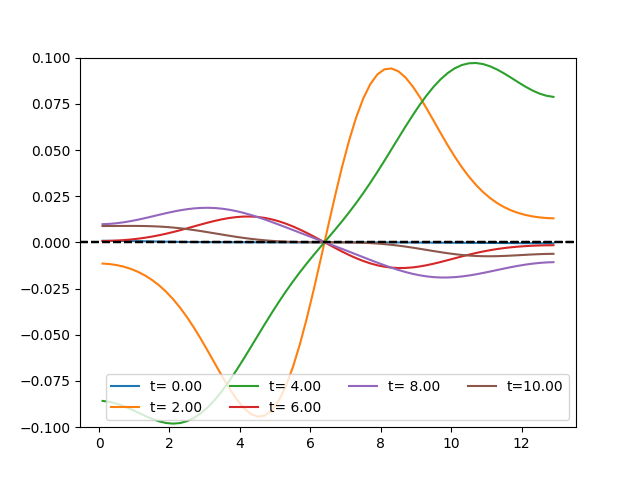

In [10]:
profiles(times, x, E, -0.1, 0.1)

In [11]:
x, Ps   = get_pressures(r,times, sigma=0)

KeyError: 'rho'

In [12]:
profiles(times, x, Ps, -0.2, 8)

NameError: name 'Ps' is not defined

# Phase space representation

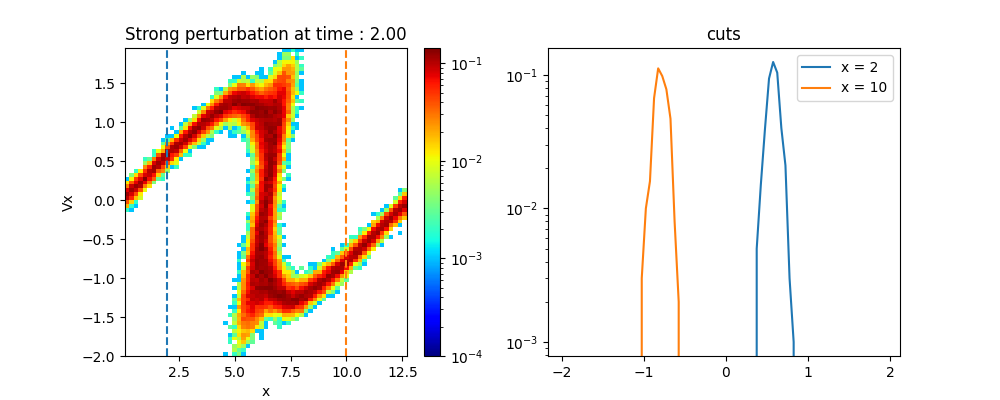

In [13]:
fig, ax1, ax2, p, f = phase_space(2, r, xcuts=(2,10))

In [14]:
fig, ax1, ax2, p, f = phase_space(4, r, xcuts=(2,10))/

SyntaxError: invalid syntax (1938651579.py, line 1)

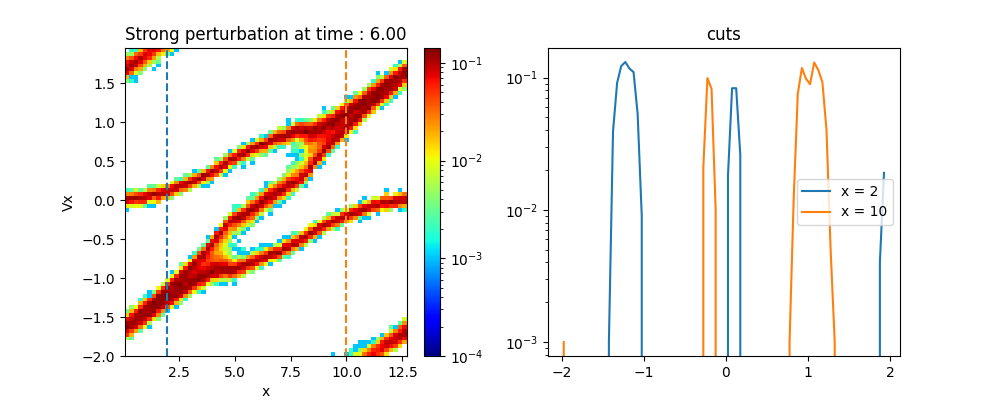

In [15]:
fig, ax1, ax2, p, f = phase_space(6, r, xcuts=(2,10))

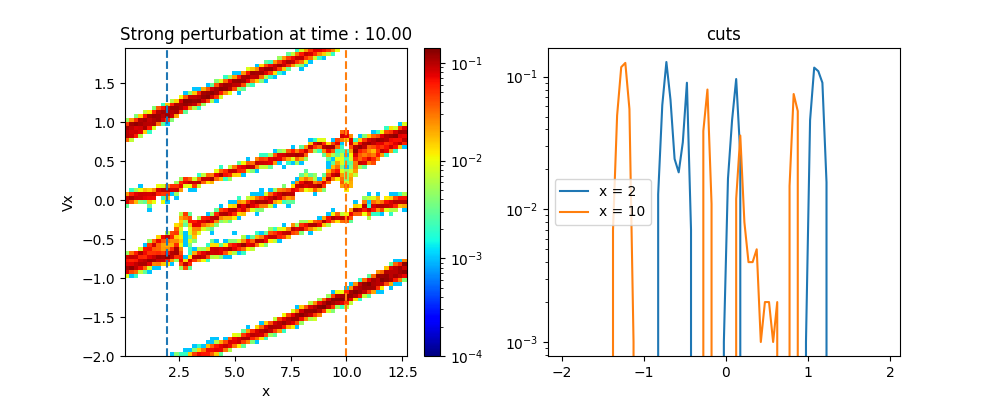

In [16]:
fig, ax1, ax2, p, f = phase_space(10, r, xcuts=(2,10))